# Simulating the nucleosynthesis of elements in stars

In [102]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate

In [103]:
NA = 6.022e23

Construct a series of differential equations to simulate the nucleosynthesis of elements in stars due to the CNO1 cycle.

The differential equations are given by:

\begin{align}
\frac{d C12}{dt} &= H \left(N15 \right) \langle \sigma v \rangle_{N15 (p,\alpha)} - H \left(C12 \right) \langle \sigma v \rangle_{C12 (p,\gamma)} \\
\frac{d C13}{dt} &= H \left(C12 \right) \langle \sigma v \rangle_{C12 (p,\gamma)} - H \left(C13 \right) \langle \sigma v \rangle_{C13 (p,\gamma)} \\
\frac{d N14}{dt} &= H \left(C13 \right) \langle \sigma v \rangle_{C13 (p,\gamma)} - H \left(N14 \right) \langle \sigma v \rangle_{N14 (p,\gamma)} \\
\frac{d N15}{dt} &= H \left(N14 \right) \langle \sigma v \rangle_{N14 (p,\gamma)} - H \left(N15 \right) \langle \sigma v \rangle_{N15 (p,\alpha)} \\
\end{align}

Where:
- $H(X)$ is the relative abundance of element $X$.
- $\langle \sigma v \rangle_{X (p,\gamma/\alpha)}$ is the reaction rate of the reaction $X (p,\gamma/\alpha)$ determined by the following equation:

\begin{align}
\langle \sigma v \rangle_{X (p,\gamma/\alpha)} &= \int_0^{\infty} v \sigma(v) P(v) dv \\
&= \left( \frac{8}{\pi m_{01}}\right)^{1/2} \frac{1}{(kT)^{3/2}} \int_0^{\infty} E \sigma(E) e^{-E/kT} dE
\end{align}

Where:
- $m_{01}$ is the reduced mass of the system.
- $k$ is the Boltzmann constant.
- $T$ is the temperature of the star's core.
- $E$ is the energy
- $\sigma(E)$ is the cross section of the reaction.

Note: We ignore the reactions involving $O16$ and $N13$ because they decay very quickly relative to the other elements.

In [104]:
def CNO1_cycle(elements:dict, temp=15e6)->dict:
    """
    Construct the differential equations for systems of the CNO1 cycle.

    Parameters
    ----------
    elements : dict
        Dictionary containing the current values of the initialAbundances.
    masses : dict
        Masses of the initialAbundances in the system.
    temp : float
        The temperature of the system in Kelvin. Default is 15 million Kelvin.
    crossSection : float
        The cross-section of the reaction. Default is 1 for the time being.

    Returns
    -------
    dX : dict
        The differential equations for the system.
    """

    t9 = temp/1e9 # convert to 10^9 K

    reaction_rates = {
        "C12(p,g)N13": 2.04e7/(t9**(2/3)) * np.exp(-13.690/(t9**(1/3)) - (t9/1.500)**2),
        "C13(p,g)N14": 8.01e7/(t9**(2/3)) * np.exp(-13.717/(t9**(1/3)) - (t9/2)**2),
        "N14(p,g)O15": 4.90e7/(t9**(2/3)) * np.exp(-15.228/(t9**(1/3)) - (t9/3.294)**2),
        "N15(p,a)C12": 1.08e12/(t9**(2/3)) * np.exp(-15.251/(t9**(1/3)) - (t9/0.522)**2)
    }

    C12toC13 = reaction_rates["C12(p,g)N13"] * elements.get('C12', 0) / elements['H1']
    C13toN14 = reaction_rates["C13(p,g)N14"] * elements.get('C13', 0) / elements['H1']
    N14toN15 = reaction_rates["N14(p,g)O15"] * elements.get('N14', 0) / elements['H1']
    N15toC12 = reaction_rates["N15(p,a)C12"] * elements.get('N15', 0) / elements['H1']


    dX = {
        'H1': -C12toC13 - N15toC12 - C13toN14 - N14toN15,
        'He4': N15toC12,
        'C12': N15toC12 - C12toC13,
        'C13': C12toC13 - C13toN14,
        'N14': C13toN14 - N14toN15,
        'N15': N14toN15 - N15toC12
    }

    return dX

The CNO2 cycle is a series of reactions that occur in stars that are more massive than the Sun. The CNO2 cycle is similar to the CNO1 cycle, but it involves the elements $N14$, $N15$, $O15$, $O16$, $O17$, and $F17$.

Due to the larger masses of the elements involved in the CNO2 cycle, these reactions are typically less likely to occur than the reactions in the CNO1 cycle. We expect this cycle to therefore have a smaller impact on the abundance of elements in the star's core.

The differential equations for the CNO2 cycle are given by:

\begin{align}
\frac{d N14}{dt} &= H \left(O17 \right) \langle \sigma v \rangle_{O17 (p,\alpha)} - H \left(N14 \right) \langle \sigma v \rangle_{N14 (p,\gamma)} \\
\frac{d N15}{dt} &= H \left(N14 \right) \langle \sigma v \rangle_{N14 (p,\gamma)} - H \left(N15 \right) \langle \sigma v \rangle_{N15 (p,\gamma)} \\
\frac{d O16}{dt} &= H \left(N15 \right) \langle \sigma v \rangle_{N15 (p,\gamma)} - H \left(O16 \right) \langle \sigma v \rangle_{O16 (p,\gamma)} \\
\frac{d O17}{dt} &= H \left(O16 \right) \langle \sigma v \rangle_{O16 (p,\gamma)} - H \left(O17 \right) \langle \sigma v \rangle_{O17 (p,\alpha)} \\
\end{align}

Due to the very short half lives of $O15$ and $F17$, we ignore these elements in our simulation and assume they all decay immediately to $N15$ and $O17$ respectively.

In [105]:
def CNO2_cycle(elements:dict, temp=15e6)->dict:
    """
    Construct the differential equations for systems of the CNO1 cycle.

    Parameters
    ----------
    elements : dict
        Dictionary containing the current values of the initialAbundances.
    masses : dict
        Masses of the initialAbundances in the system.
    temp : float
        The temperature of the system in Kelvin. Default is 15 million Kelvin.
    crossSection : float
        The cross-section of the reaction. Default is 1 for the time being.

    Returns
    -------
    dX : dict
        The differential equations for the system.
    """

    t9 = temp/1e9 # convert to 10^9 K

    reaction_rates = {
        "N14(p,g)O15": 4.90e7/(t9**(2/3)) * np.exp(-15.228/(t9**(1/3)) - (t9/3.294)**2),
        "N15(p,g)O16": 9.78e8/(t9**(2/3)) * np.exp(-15.251/(t9**(1/3)) - (t9/0.450)**2),
        "O16(p,g)F17": 1.50e8/(t9**(2/3) * (1 + 2.13*(1 - np.exp(-0.728 * t9**(2/3))))) * np.exp(-16.692/(t9**(1/3))),
        "O17(p,a)N14": 1.53e7/(t9**(2/3)) * np.exp(-16.712/(t9**(1/3)) - (t9/0.565)**2)
    }

    N14toN15 = reaction_rates["N14(p,g)O15"] * elements.get('N14', 0) / elements['H1']
    N15toO16 = reaction_rates["N15(p,g)O16"] * elements.get('N15', 0) / elements['H1']
    O16toO17 = reaction_rates["O16(p,g)F17"] * elements.get('O16', 0) / elements['H1']
    O17toN14 = reaction_rates["O17(p,a)N14"] * elements.get('O17', 0) / elements['H1']

    dX = {
        "H1": -N14toN15 - N15toO16 - O16toO17 - O17toN14,
        "He4": O17toN14,
        "N14": O17toN14 - N14toN15,
        "N15": N14toN15 - N15toO16,
        "O16": N15toO16 - O16toO17,
        "O17": O16toO17 - O17toN14
    }

    return dX

In [106]:
def C12_He4_to_O16(elements: dict, temp=15e6) -> dict:
    """
    Construct the differential equations for the reaction
    12C + 4He -> 16O + γ without the reverse reaction.

    Parameters
    ----------
    elements : dict
        Dictionary containing the current abundances of elements.
    temp : float
        The temperature of the system in Kelvin. Default is 15 million Kelvin.

    Returns
    -------
    dX : dict
        The differential equations for the system.
    """

    t9 = temp / 1e9  # Convert to 10^9 K

    # Forward reaction rate for 12C(α,γ)16O
    forward_rate =  1.04e8 * (t9 ** 2) /( np.exp(1+0.0489 * (t9 ** 2/3)**2))


    C12toO16 = forward_rate * elements.get('C12', 0) * elements.get('He4', 0) / elements['H1']

    dX = {
        'C12': -C12toO16,
        'He4': -C12toO16,
        'O16': C12toO16
    }

    return dX


In [107]:
def integrate_system(elements:dict, temp=15e6)->tuple:
    """
    Integrate the system of differential equations.

    Parameters
    ----------
    elements : dict
        Dictionary containing the initial values of the initialAbundances.
    temp : float
        The temperature of the system in Kelvin. Default is 15 million Kelvin for the core of the Sun.

    Returns
    -------
    times : ndarray
        Array containing the time steps.
    X : ndarray
        Array containing the values of the initialAbundances.

    """

    # tMax = 1e18
    tMax = 1e17
    dT = tMax/1000

    t = np.arange(0, tMax+dT, dT)


    X = []
    X.append(elements)

    for _ in range(1, len(t)):
        newX = X[-1].copy()
        dCNO1 = CNO1_cycle(newX, temp)
        dCNO2 = CNO2_cycle(newX, temp)
        dC12He4O16 = C12_He4_to_O16(newX, temp)

        for elem, dX in dCNO1.items():
            newX[elem] = newX.get(elem, 0) + dX*dT/NA

        for elem, dX in dCNO2.items():
            newX[elem] = newX.get(elem, 0) + dX*dT/NA


        for elem, dX in dC12He4O16.items():
           newX[elem] = newX.get(elem, 0) + dX * dT / NA

        X.append(newX)

    return t, X

In [108]:
elementMasses = {
    'H1': 1.007825,
    'He4': 4.002603,
    'C12': 12.000000,
    'C13': 13.003355,
    'N14': 14.003074,
    'N15': 15.000109,
    'O16': 15.994915,
    'F17': 17.002095,
    'O17': 16.999132
} # in atomic mass units


H1 = 6e26 # Initial abundance of Hydrogen in the Sun

initialAbundances = {
    'H1': H1,
    'He4': H1*0.25,
    'C12': H1*0.087,
    # 'C13': 0,
    'N14': H1*0.000082,
    # 'N15': 0,
    # 'O16': 0,
    # 'O17': 0
}

In [109]:
# plot the results
times, X = integrate_system(initialAbundances)

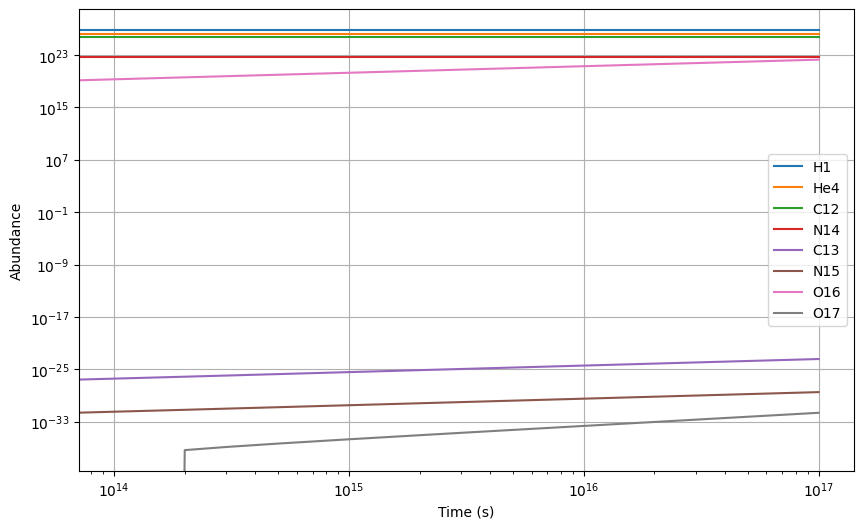

In [110]:

plt.figure(figsize=(10, 6))
for elem in X[-1].keys():
    plt.loglog(times, [x.get(elem,0) for x in X], label=elem)
plt.xlabel('Time (s)')
plt.ylabel('Abundance')
# plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [111]:
for elem, value in X[-1].items():
    print(f"{elem}: {value}")

H1: 6e+26
He4: 1.4998134966474133e+26
C12: 5.218134966474112e+25
N14: 4.92e+22
C13: 3.779551001688423e-24
N15: 3.350107465032132e-29
O16: 1.8650335258926912e+22
O17: 2.348708123533718e-32
